# **Behavioral Cloning**

---

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report

Getting started
--------------

### Installation & Download

To get started with this project, you need to install and download below:

#### Dependencies

- [Keras](https://keras.io/)
- [NumPy](http://www.numpy.org/)
- [SciPy](https://www.scipy.org/)
- [Scikit-Learn](http://scikit-learn.org/stable/install.html)
- [TensorFlow](http://tensorflow.org)
- [Pandas](http://pandas.pydata.org/)
- [OpenCV](http://opencv.org/)

#### Simulator
 
- [Windows 64 bit](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/5831f3a4_simulator-windows-64/simulator-windows-64.zip)
- [macOS](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/5831f290_simulator-macos/simulator-macos.zip)  
- [Linux](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/5831f0f7_simulator-linux/simulator-linux.zip)  
 
 
#### Dataset
 
- [Udacity dataset] (Track1 data provided by Udacity)

[Udacity dataset]: https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip

### Run Model

After run simulator as autonomous mode type below in terminal.

    $ python drive.py model.h5

### Train Model

    $ python model.py
    
Model Architecture and Training Strategy
--------------------------------------

### 1. Model Architecture
I used [NVIDIA's End to End Learning for Self-Driving Cars][] paper almost as it is. My model consisted of 5 convolutional neural networks with 5x5 and 3x3 filter size, and 4 fully connected layers. The model includes ELU layers for activation, and the data is normalized in the model using a Keras BatchNormalization layer.

![Model Architecture][model_architecture]
[NVIDIA's End to End Learning for Self-Driving Cars]: http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
[model_architecture]: ./images/model_architecture.jpg


### 2. Train data

I used [Udacity dataset] provided with this project that contains Track 1 data.

Udacity dataset consists of 24108 images(8036 images for left, right and center camera). I choose randomly among left, right and center images, and add correction for left and right images.

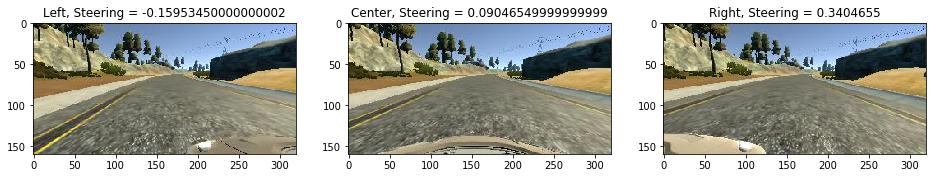

In [1]:
import numpy as np
import cv2

import helper
import matplotlib.pyplot as plt
%matplotlib inline

def imread_rgb(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

log = helper.get_data_from_log()

index = np.random.randint(len(log))
correction = 0.25

center = imread_rgb(log['center'][index])
left = imread_rgb(log['left'][index])
right = imread_rgb(log['right'][index])
steering = log['steering'][index]

fig, axarr = plt.subplots(1, 3, figsize=(16, 32))

axarr[0].imshow(left)
axarr[0].set_title('Left, Steering = {}'.format(steering - correction))

axarr[1].imshow(center)
axarr[1].set_title('Center, Steering = {}'.format(steering))

axarr[2].imshow(right)
axarr[2].set_title('Right, Steering = {}'.format(steering + correction))

plt.show()

### 3. Data augmentation

After load image, it is augmented according to the process below.

Image -> Crop and resize -> Random brightness -> Random translation -> Random flip

#### 1. Crop and resize

In the first stage, image is cropped and resized to reduce train noises and time.

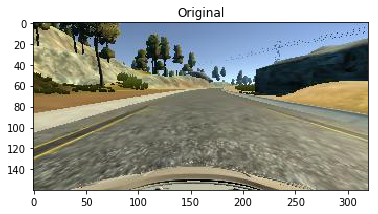

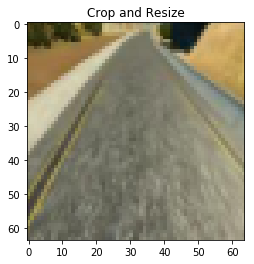

In [2]:
index = 0

image = center
cropped = helper.crop_and_resize(image)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Original')
ax.imshow(image)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Crop and Resize')
ax.imshow(cropped)

plt.show()

#### 2. Random brightness

In the second step, the brightness of the image is randomly adjusted. Brightness adjustment is important because shadows are generated in simulator fast mode or above.

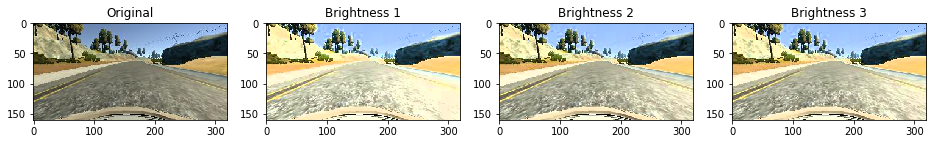

In [3]:
fig, axarr = plt.subplots(1, 4, figsize=(16, 32))

axarr[0].imshow(image)
axarr[0].set_title('Original')

for i in range(1, 4):
    axarr[i].imshow(helper.random_brightness(image))
    axarr[i].set_title('Brightness {}'.format(i))

plt.show()

#### 3. Random translation

This is the most important stage I think. Before add this stage, the car couldn't finish the track.

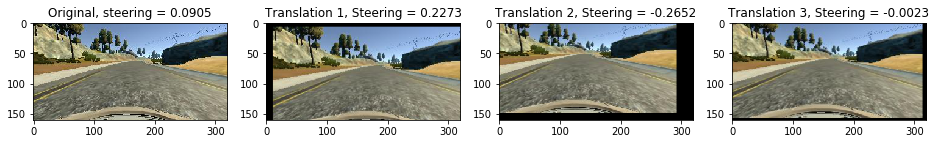

In [4]:
fig, axarr = plt.subplots(1, 4, figsize=(16, 32))

axarr[0].imshow(image)
axarr[0].set_title('Original, steering = {:.4f}'.format(steering))

for i in range(1, 4):
    translated_image, translated_steering = helper.random_translate(image, steering)
    axarr[i].imshow(translated_image)
    axarr[i].set_title('Translation {}, Steering = {:.4f}'.format(i, translated_steering))

plt.show()

#### 4. Random flip

In the last stage, the image is randomly flipped.

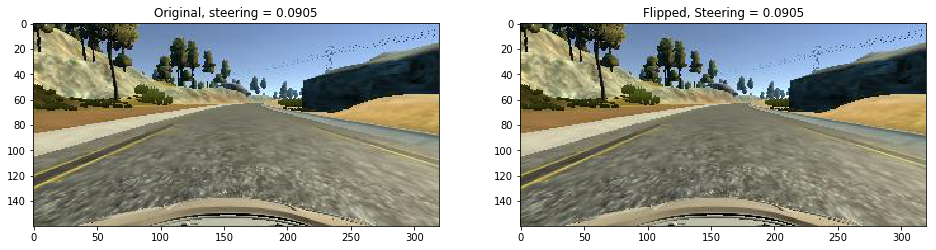

In [5]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 32))

axarr[0].imshow(image)
axarr[0].set_title('Original, steering = {:.4f}'.format(steering))

flipped_image, flipped_steering = helper.random_flip(image, steering)
axarr[1].imshow(flipped_image)
axarr[1].set_title('Flipped, Steering = {:.4f}'.format(flipped_steering))

plt.show()

#### 5. Apply all above

The image used in the actual training is to apply all the above methods.

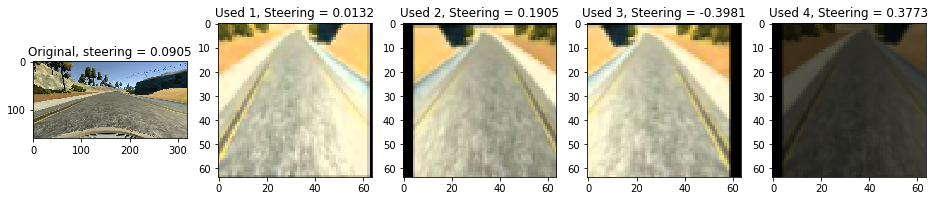

In [6]:
fig, axarr = plt.subplots(1, 5, figsize=(16, 32))

axarr[0].imshow(image)
axarr[0].set_title('Original, steering = {:.4f}'.format(steering))

for i in range(1, 5):
    processed_image, processed_steering = helper.process_image(image, steering)
    axarr[i].imshow(processed_image)
    axarr[i].set_title('Used {}, Steering = {:.4f}'.format(i, processed_steering))

plt.show()

### 4. Training

#### 1. Generator

I used generator for generating data instead of putting all the data in memory. It shuffles the data every epoch.

```python
def generate_batch(samples, batch_size=128):
    """Reads images from samples by batch size and returns it.
    """
    num_samples = len(samples)

    while True:
        new_samples = get_shuffled_dataframe(samples)
        for offset in range(0, num_samples, batch_size):
            images = []
            steerings = []
            start = offset
            end = offset + batch_size
            end = num_samples if end > num_samples else end

            for i in range(start, end):
                image, steering = get_new_image(new_samples, i)

                images.append(image)
                steerings.append(steering)

            batch_x = np.array(images)
            batch_y = np.array(steerings)

            yield shuffle(batch_x, batch_y)
```

#### 2. Training parameters

- Activation: Elu
- Optimizer: Adam
- Batch Size: 128
- Epochs: 8
- Train/Validation split: 0.2
